## Consistency of the EnKF and the EnRF

In [1]:
using Revise
using PDMats
using Distributions
using TransportBasedInference
using RobustFilter
using LinearAlgebra
using SpecialFunctions
using Statistics
using Test
using ProgressMeter

In [86]:
# using Makie
using CairoMakie
using MakieTeX

[ Info: Precompiling MakieTeX [6d554a22-29e7-47bd-aee5-0c5f06619414]


In [10]:
# using Plots
# default(tickfont = (9, "CMU Serif"), 
#         titlefont = font("CMU Serif", 14), 
#         guidefont = font("CMU Serif", 12),
#         legendfont = (10, "CMU Serif"),
#         grid = false)
# # Plots.font("sans-serif")
# # clibrary(:colorbrewer)
# gr()
# # pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
# rcParams["text.usetex"] = true;
# PyPlot.rc("font", family = "CMU Serif")
# PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
# PyPlot.matplotlib[:rc]("font",family="serif",size=12)

using ColorSchemes

In [11]:
# clibrary(:colorbrewer)
# default(clim = (-0.05, 0.05), markerstrokealpha = 0, markersize = 6, grid = false, xtickfontsize = 12, 
#     legendfontsize = 12,
#     ytickfontsize = 12,
#      legend = true, colorbar = :right)


c_enkf = colorant"cornflowerblue"
c_fixedenrf = colorant"gold"
c_refreshenrf = colorant"tomato2"
c_adaptenrf = colorant"seagreen3"

In [12]:
# Distributions.jl takes as input the scale matrix C
Nx = 10
Ny = 5
ν = 2.5

Cjointyx = PDiagMat(ones(Ny + Nx))
πyx = Distributions.GenericMvTDist(ν, zeros(Ny+Nx), Cjointyx)


Py = hcat(Matrix(1.0*I, Ny, Ny), zeros(Ny, Nx))
Px = hcat(zeros(Nx, Ny), Matrix(1.0*I, Nx, Nx))

# Marginal distributions

μy = Py*πyx.μ
Cy = PDMat(Py*scale(πyx)*Py')
πy = Distributions.GenericMvTDist(πyx.df, μy, Cy)

μx = Px*πyx.μ
Cx = PDMat(Px*scale(πyx)*Px')
πx = Distributions.GenericMvTDist(πyx.df, μx, Cx)

# Conditional distributions
α(T::MvTDist, t::Vector{Float64}) = (T.df + Distributions.sqmahal(T, t))/(T.df + length(T))

Cyx = Py*scale(πyx)*Px'
Σyx = Py*cov(πyx)*Px'

Cxy = Matrix(Cyx')
Σxy = Matrix(Σyx')


μygivenx(x) = πy.μ + Cyx*(scale(πx)\(x - πx.μ))

Cygivenx(x) = PDMat(α(πx, x)*(scale(πy) - Cyx*(scale(πx)\Cyx')))

πygivenx(x) = Distributions.GenericMvTDist(πyx.df + length(πx), μygivenx(x), Cygivenx(x))

μxgiveny(y) = πx.μ + Cxy*(scale(πy)\(y - πy.μ))

Cxgiveny(y) = PDMat(α(πy, y)*(scale(πx) - Cxy*(scale(πy)\Cxy')))

πxgiveny(y) = Distributions.GenericMvTDist(πyx.df + length(πy), μxgiveny(y), Cxgiveny(y))

πxgiveny (generic function with 1 method)

In [13]:
# Compute analytical statistics of the EnKF
μpost_enkf(y) = πx.μ + Σxy*inv(cov(πy))*(y - πy.μ)
Σpost_enkf(y) = cov(πx) - Σxy*inv(cov(πy))*Σxy'

# Compute analytical statistics of the EnRF
μpost_enrf(y) = πx.μ + Cxy*inv(scale(πy))*(y - πy.μ)
Σpost_enrf(y) = α(πy, y)*(scale(πx) - Cxy*inv(scale(πy))*Cxy')

Σpost_enrf (generic function with 1 method)

In [14]:
for i=1:10
    yxstar = rand(πyx)
    @test isapprox(pdf(πyx, yxstar), pdf(πy, Py*yxstar)*pdf(πxgiveny(Py*yxstar), Px*yxstar), atol = 1e-10)
    @test isapprox(pdf(πyx, yxstar), pdf(πx, Px*yxstar)*pdf(πygivenx(Px*yxstar), Py*yxstar), atol = 1e-10)
end

In [15]:
function test_enkf(YX, ystar)
    Ny = size(ystar, 1)
    Nypx = size(YX, 1)
    Nx = Nypx - Ny
    Ne = size(YX, 2)
    
    Y = YX[1:Ny,:]
    Xprior = YX[Ny+1:Ny+Nx,:]
    
    μYX = mean(YX, dims = 2)[:,1]
    AYX = 1/sqrt(Ne-1)*(YX .- μYX)
    
    μX = μYX[Ny+1:Ny+Nx]
    AX = AYX[Ny+1:Ny+Nx,:]
    
    μY = μYX[1:Ny]
    AY = AYX[1:Ny, :]
    
    K = AX*(AY')*inv(AY*AY')
    
    Xpost = Xprior - K*(Y .- ystar)
    return Xprior, Xpost
end

test_enkf (generic function with 1 method)

In [16]:
function test_enrf(YX, ystar)
    λ = 1e-10
    
    Ny = size(ystar, 1)
    Nypx = size(YX, 1)
    Nx = Nypx - Ny
    Ne = size(YX, 2)
    
    Y = YX[1:Ny,:]
    Xprior = YX[Ny+1:Ny+Nx,:]
    Xpost = zero(Xprior)
    
    μYXlasso, CYXlasso, νYXlasso  = regularized_EM_tdist(YX, 1.0/sqrt(Ne); Niter = 500,
                                                                       tol = 1e-2, νX = νX_DEFAULT)   
    
    μY = μYXlasso[1:Ny]
    CY = CYXlasso[1:Ny, 1:Ny]
    # θY = inv(CY)#θYXlasso[1:Ny,1:Ny]
    
    νY = copy(νYXlasso)

    μX = μYXlasso[Ny+1:Ny+Nx]
    # Cross scale matrix between X and Y.
    CXcrossY = CYXlasso[Ny+1:Ny+Nx,1:Ny]

    # Cholesky factorization of the precision matrix CY = LY LY^⊤
    LY = LowerTriangular(cholesky(Symmetric(CY)).L)

    # bstar = θY * (ystar - μY)
    # αstar = (νY + (ystar - μY)'*θY*(ystar - μY))/(νY+ Ny)


    zstar = LY \ (ystar - μY)
    bstar = LY' \ zstar
    αstar = (νY + sum(abs2, zstar))/(νY+ Ny)

    for i=1:Ne
        xi = Xprior[:,i]
        yi = Y[:,i]
        # zi = RY \ (yi - μY)
        zi = LY \ (yi - μY)

        αi = (νY + sum(abs2, zi))/(νY+ Ny)

        # αi = (νY + (yi - μY)'*θY*(yi - μY))/(νY + Ny)
        # bi = RY' \ zi
        bi = LY' \ zi
        # bi = θY*(yi - μY)

        # @show νY, αstar, αstar/αi, sqrt(αstar/αi), norm(zstar)^2, norm(zi)^2#, norm(AX*(AY)'*bstar - AX*(AY)'*bi - (ystar - yi))
        Xpost[:,i] =  μX + CXcrossY*bstar + sqrt(αstar/αi)*((xi - μX) - CXcrossY*bi)
    end

    return Xprior, Xpost
end

test_enrf (generic function with 1 method)

In [17]:
Nrun = 1000 
Ne_list = [30; 40; 50; 60; 80; 100; 120; 150; 200; 400; 600; 1000];

In [165]:
# Error in the mean
eμ_finite_xstar_enkf = zeros(length(Ne_list), Nrun)
eμ_finite_xstar_enrf = zeros(length(Ne_list), Nrun)

eμ_finite_truepost_enkf = zeros(length(Ne_list), Nrun)
eμ_finite_truepost_enrf = zeros(length(Ne_list), Nrun)

eμ_finite_infinite_enkf = zeros(length(Ne_list), Nrun)
eμ_finite_infinite_enrf = zeros(length(Ne_list), Nrun)

# Error in the covariance
eΣ_finite_truth_enkf = zeros(length(Ne_list), Nrun)
eΣ_finite_truth_enrf = zeros(length(Ne_list), Nrun)

spread_enkf = zeros(length(Ne_list), Nrun)
spread_enrf = zeros(length(Ne_list), Nrun)


dystar = zeros(Nrun)


@showprogress for j =1:Nrun
    
    yxstar = rand(πyx)
    ystar = Py*yxstar
    xstar = Px*yxstar
    
    dystar[j] = Distributions.sqmahal(πy, ystar)
    
    for (i, Nei) in enumerate(Ne_list)


        YX = rand(πyx, Nei)

        Xprior_enkf, Xenkf = test_enkf(YX, ystar)
        Xprior_enrf, Xenrf = test_enrf(YX, ystar)
        
        # @test isapprox(Xprior_enkf, Xprior_enrf, atol = 1e-10)

        # Compute sample statistics
        μhatenkf = mean(Xenkf, dims = 2)[:,1]
        μhatenrf = mean(Xenrf, dims = 2)[:,1]

        Σhatenkf = cov(Xenkf, dims = 2)
        Σhatenrf = cov(Xenrf, dims = 2)

        # Compute error between the sample mean and xstar
        eμ_finite_xstar_enkf[i,j] = deepcopy(norm(μhatenkf - xstar)/sqrt(Nx))
        eμ_finite_xstar_enrf[i,j] = deepcopy(norm(μhatenrf - xstar)/sqrt(Nx))

        # Compute error between the sample mean and the true posterior mean
        eμ_finite_truepost_enkf[i,j] = deepcopy(norm(μhatenkf - μxgiveny(ystar))/sqrt(Nx))
        eμ_finite_truepost_enrf[i,j] = deepcopy(norm(μhatenrf - μxgiveny(ystar))/sqrt(Nx))

        # Compute error between the sample mean and the asymptotic mean of the EnKF and the EnRF
        eμ_finite_infinite_enkf[i,j] = deepcopy(norm(μhatenkf - μpost_enkf(ystar))/sqrt(Nx))
        eμ_finite_infinite_enrf[i,j] = deepcopy(norm(μhatenrf - μpost_enrf(ystar))/sqrt(Nx))

        # Compute error between the sample covariance and the exact one from the posterior
        eΣ_finite_truth_enkf[i,j] = deepcopy(norm(Σhatenkf - cov(πxgiveny(ystar)))/sqrt(Nx))
        eΣ_finite_truth_enrf[i,j] = deepcopy(norm(Σhatenrf - cov(πxgiveny(ystar)))/sqrt(Nx))
        
        spread_enkf[i,j] = deepcopy(sqrt(tr(Σhatenkf)/Nx))
        spread_enrf[i,j] = deepcopy(sqrt(tr(Σhatenrf)/Nx))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:16


This graph compares the mean RMSE (over Nrun realizations) between the true state $x^\star$ and the posterior sample mean predicted by the EnKF and the EnRF:
$$\mbox{RMSE } \hat{\mu}_{filter} - x^\star  = \frac{||\hat{\mu}_{filter} - x^\star||}{\sqrt{N_x}}$$

In [145]:
plt = plot(xlabel = L"M", ylabel = L"\mbox{RMSE } \hat{\mu}_{filter} - x^\star ")
           #xlim = (50, Inf), ylim = (-Inf, Inf))
plot!(Ne_list, mean(eμ_finite_xstar_enkf, dims = 2)[:, 1], label = "EnKF")#, yscale)
plot!(Ne_list, mean(eμ_finite_xstar_enrf, dims = 2)[:, 1], label = "EnRF")

LoadError: PlotMethodError: no [36mplot[39m method for arguments [36m()[39m. To support these arguments, define
  [36mplot!(::Combined{Any, S} where S<:Tuple{})[39m
Available methods are:


In [146]:
plt = plot(xlabel = L"M", ylabel = L"\mbox{RMSE } \hat{\mu}_{filter} - \mu_{filter}")
plot!(Ne_list, mean(eμ_finite_infinite_enkf, dims = 2)[:, 1], label = L"\mbox{EnKF}", yscale = :log10, linewidth = 3, color = c_enkf)
plot!(Ne_list, mean(eμ_finite_infinite_enrf, dims = 2)[:, 1], label = "EnRF", yscale = :log10, linewidth = 3, color = c_adaptenrf)

LoadError: PlotMethodError: no [36mplot[39m method for arguments [36m()[39m. To support these arguments, define
  [36mplot!(::Combined{Any, S} where S<:Tuple{})[39m
Available methods are:


In [209]:
saveplot = true

true

### The two following graphs are the same

This graph compares the mean RMSE (over Nrun realizations) between the posterior asymptotic and sample mean predicted by the EnKF and the EnRF:
$$\mbox{RMSE } \hat{\mu}_{filter} - \mu_{filter}  = \frac{||\hat{\mu}_{filter} - \mu_{filter}||}{\sqrt{N_x}}$$

In [210]:
plt = plot(xlabel = L"M", ylabel = L"\mbox{RMSE } \hat{\mu}_{filter} - \mu_{filter}")
plot!(Ne_list, mean(eμ_finite_infinite_enkf, dims = 2)[:, 1], label = "EnKF", yscale = :log10, linewidth = 3, color = c_enkf)
plot!(Ne_list, mean(eμ_finite_infinite_enrf, dims = 2)[:, 1], label = "EnRF", yscale = :log10, linewidth = 3, color = c_adaptenrf)

LoadError: PlotMethodError: no [36mplot[39m method for arguments [36m()[39m. To support these arguments, define
  [36mplot!(::Combined{Any, S} where S<:Tuple{})[39m
Available methods are:


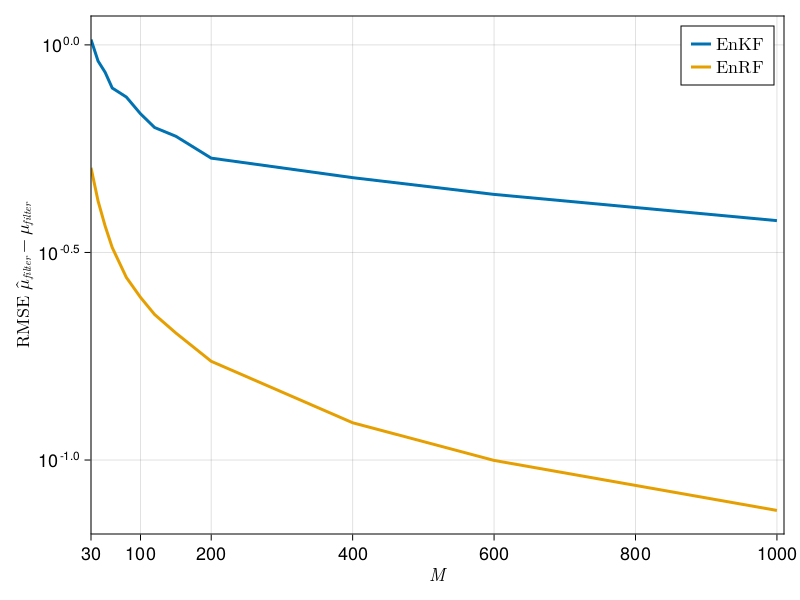

In [211]:
f = Figure(fontsize = 18, grid = false, font = "TeX Heros Italic")

ax = Axis(f[1,1],
     xlabel = L"M",
     xticks = [30, 100, 200, 400, 600, 800, 1000],
     yscale = log10,
     ylabel = L"\text{RMSE } \hat{\mu}_{filter} - \mu_{filter}"
)
lines!(ax, Ne_list, mean(eμ_finite_infinite_enkf, dims = 2)[:, 1], label  = L"\text{EnKF}", linewidth = 3, 
    font = "CMU serif")
lines!(ax, Ne_list, mean(eμ_finite_infinite_enrf, dims = 2)[:, 1], label  = L"\text{EnRF}", linewidth = 3)
xlims!(ax, [30, 1010])
axislegend()
resize_to_layout!(f)
f

This graph compares the mean RMSE (over Nrun realizations) between  the sample mean predicted by the EnKF and the EnRF with the true posterior mean:
$$\mbox{RMSE } \hat{\mu}_{filter} - \mu_{X | y^\star}  = \frac{||\hat{\mu}_{filter} - \mu_{X | y^\star}||}{\sqrt{N_x}}$$

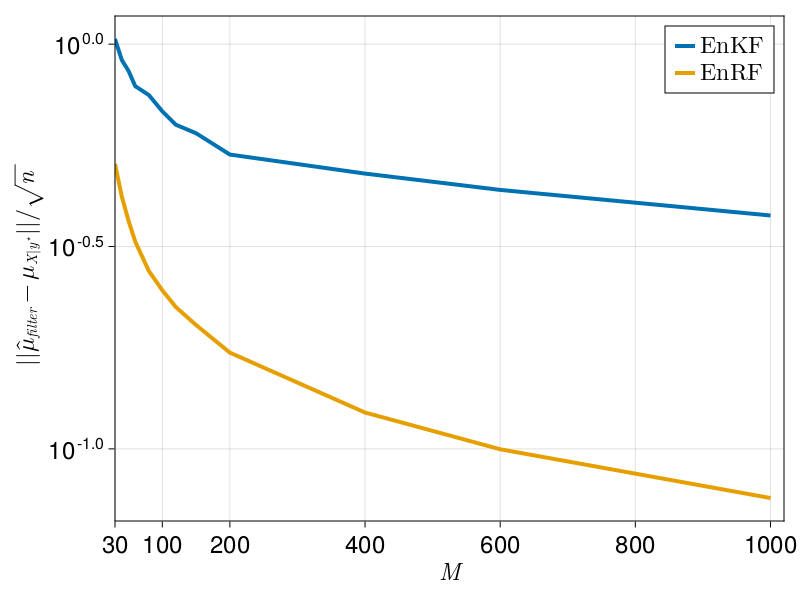

In [212]:
f = Figure(fontsize = 24, grid = false, font = "TeX Heros Italic")

ax = Axis(f[1,1],
     xlabel = L"M",
     xticks = [30, 100, 200, 400, 600, 800, 1000],
     yscale = log10,
     ylabel = L"||\hat{\mu}_{filter} - \mu_{X | y^\star}||/\sqrt{n}"
)
lines!(ax, Ne_list, mean(eμ_finite_truepost_enkf, dims = 2)[:, 1], label  = L"\text{EnKF}", linewidth = 4, 
    font = "CMU serif")
lines!(ax, Ne_list, mean(eμ_finite_truepost_enrf, dims = 2)[:, 1], label  = L"\text{EnRF}", linewidth = 4)
xlims!(ax, [30, 1020])
axislegend()
resize_to_layout!(f)
f

saveplot && save("consistency_mean.pdf", f)
f

This graph compares the mean Frobenius norm (over Nrun realizations) between the true posterior covariance and the sample covariance predicted by the EnKF and the EnRF:
$$\mbox{RMSE } \hat{\Sigma}_{filter} - \Sigma_{X | y^\star} = \frac{||\hat{\Sigma}_{filter} - \Sigma_{X | y^\star}||_F}{\sqrt{N_x}}$$

In [213]:
# plt = plot(xlabel = L"M", ylabel = L"||\hat{\Sigma}_{filter} - \Sigma_{X | y^\star}||_F / \sqrt{n}")
# plot!(Ne_list, mean(eΣ_finite_truth_enkf, dims = 2)[:, 1], label = "EnKF", yscale = :log10, linewidth = 3, color = c_enkf)
# plot!(Ne_list, mean(eΣ_finite_truth_enrf, dims = 2)[:, 1], label = "EnRF", linewidth = 3, color = c_adaptenrf)

# annotate!(plt, 80, 10, "(b)")
# # savefig("consistency_covariance.pdf")

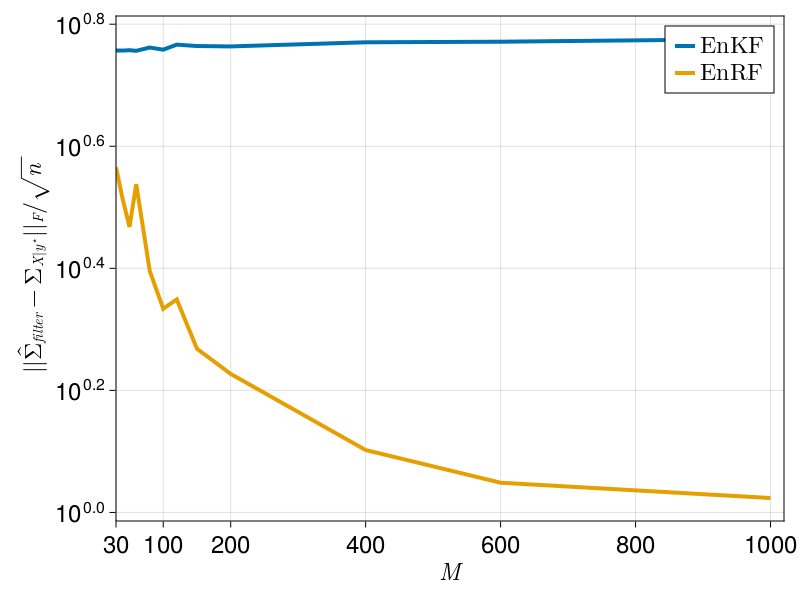

In [214]:
f = Figure(fontsize = 24, grid = false)#, font = "TeX Heros Italic")

ax = Axis(f[1,1],
     xlabel = L"M",
     xticks = [30, 100, 200, 400, 600, 800, 1000],
     yscale = log10,
     ylabel = L"||\hat{\Sigma}_{filter} - \Sigma_{X | y^\star}||_F / \sqrt{n}"
)
lines!(ax, Ne_list, mean(eΣ_finite_truth_enkf, dims = 2)[:, 1], label  = L"\text{EnKF}", linewidth = 4, 
    font = "CMU serif")
lines!(ax, Ne_list, mean(eΣ_finite_truth_enrf, dims = 2)[:, 1], label  = L"\text{EnRF}", linewidth = 4)
xlims!(ax, [30, 1020])
axislegend()
resize_to_layout!(f)
f

saveplot && save("consistency_covariance.pdf", f)
f

This graph compares the mean spread (over Nrun realizations) of the sample covariance predicted by the EnKF and the EnRF:
$$\mbox{spread } \hat{\Sigma}_{filter}  = \sqrt{\frac{\mbox{trace}(\hat{\Sigma}_{filter})}{N_x}}$$

In [215]:
# plt = plot(xlabel = L"M", ylabel = L"\sqrt{\mbox{trace}(\hat{\Sigma}_{filter})/\mbox{dim}(\mathsf{X})}")
# plot!(Ne_list,  mean(spread_enkf; dims = 2)[:,1], label = "EnKF", yscale = :log10, linewidth = 3, color = c_enkf)
# plot!(Ne_list,  mean(spread_enrf; dims = 2)[:,1], label = "EnRF", linewidth = 3, color = c_adaptenrf)

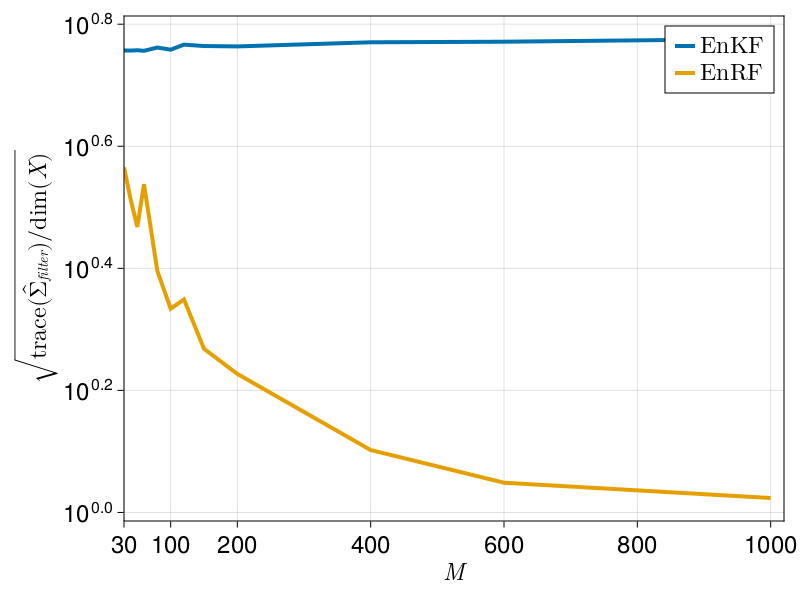

In [216]:
f = Figure(fontsize = 24, grid = false)#, font = "TeX Heros Italic")

ax = Axis(f[1,1],
     xlabel = L"M",
     xticks = [30, 100, 200, 400, 600, 800, 1000],
     yscale = log10,
     ylabel = L"\sqrt{\text{trace}(\hat{\Sigma}_{filter})/\text{dim}({X})}"
)
lines!(ax, Ne_list, mean(eΣ_finite_truth_enkf, dims = 2)[:, 1], label  = L"\text{EnKF}", linewidth = 4)
lines!(ax, Ne_list, mean(eΣ_finite_truth_enrf, dims = 2)[:, 1], label  = L"\text{EnRF}", linewidth = 4)
xlims!(ax, [30, 1020])
axislegend()
resize_to_layout!(f)
f

The spread of the EnKF is increasing as the number of samples increases as we get more and more outliers that corrupt the estimate of the covariance

Plot samples for `eμ_finite_truepost_enkf` for $M = 1000$.

In [217]:
# scatter(sort(eμ_finite_truepost_enkf[11,:]), label = "EnKF", linewidth = 3, color = c_enkf, yscale = :log10, legend = :topleft)
# scatter!(sort(eμ_finite_truepost_enrf[11,:]), label = "EnRF", linewidth = 3, color = c_adaptenrf)

# # savefig("consistency_samples_mean.pdf")

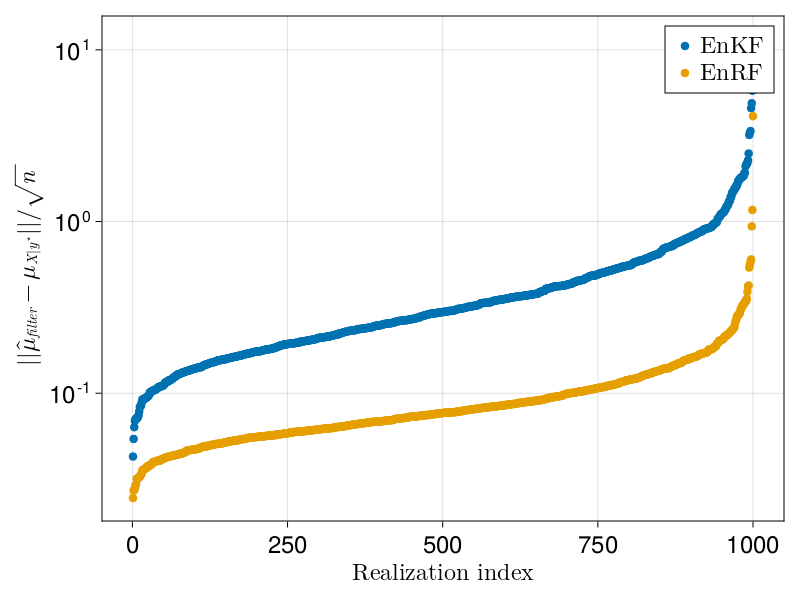

In [218]:
f = Figure(fontsize = 24, grid = false)#, font = "TeX Heros Italic")

ax = Axis(f[1,1],
     xlabel = L"\text{Realization index}",
     xticks = [0, 250, 500, 750, 1000],
     yscale = log10,
     ylabel = L"||\hat{\mu}_{filter} - \mu_{X | y^\star}||/\sqrt{n}"
)
scatter!(ax, sort(eμ_finite_truepost_enkf[11,:]), label  = L"\text{EnKF}", linewidth = 4)
scatter!(ax, sort(eμ_finite_truepost_enrf[11,:]), label  = L"\text{EnRF}", linewidth = 4)
# xlims!(ax, [30, 1020])
axislegend()
resize_to_layout!(f)
f

saveplot && save("consistency_samples_mean.pdf", f)
f

Plot samples for `eΣ_finite_truepost_enkf` for $M = 1000$.

In [219]:
# plt = plot(xlabel = "Sample index")
# scatter!(plt, sort(eΣ_finite_truth_enkf[11,:]), label = "EnKF", linewidth = 3, color = c_enkf, yscale = :log10, legend = :topleft)
# # scatter!(plt, sort(eΣ_finite_truth_enrf[11,:]), label = "EnRF", linewidth = 3, color = c_adaptenrf)

# # savefig("consistency_samples_covariance.pdf")

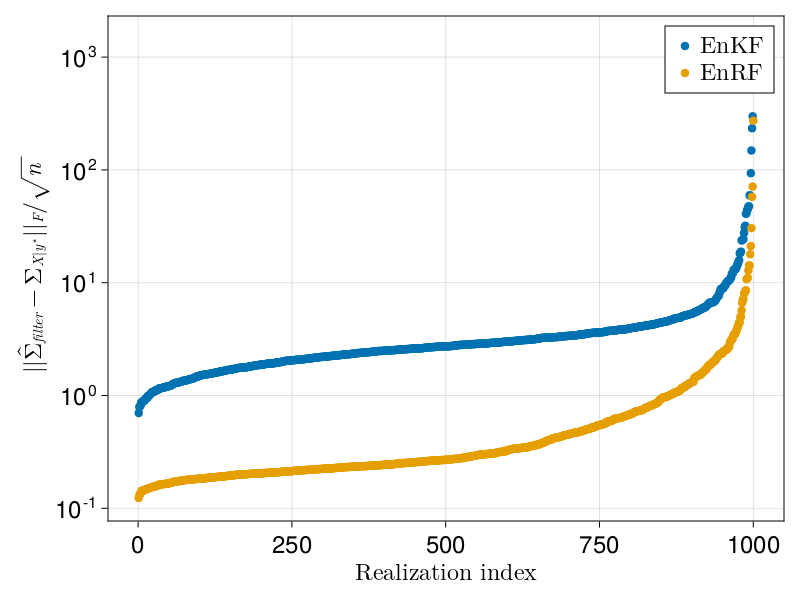

In [220]:
f = Figure(fontsize = 24, grid = false)#, font = "TeX Heros Italic")

ax = Axis(f[1,1],
     xlabel = L"\text{Realization index}",
     xticks = [0, 250, 500, 750, 1000],
     yscale = log10,
     ylabel = L"||\hat{\Sigma}_{filter} - \Sigma_{X | y^\star}||_F / \sqrt{n}"
)
scatter!(ax, sort(eΣ_finite_truth_enkf[11,:]), label  = L"\text{EnKF}", linewidth = 4)
scatter!(ax, sort(eΣ_finite_truth_enrf[11,:]), label  = L"\text{EnRF}", linewidth = 4)
# xlims!(ax, [30, 1020])
axislegend()
resize_to_layout!(f)
f

saveplot && save("consistency_samples_covariance.pdf", f)
f

In [221]:
# plt = plot(layout = grid(2,2), legend = false)
    
# # First plot 
# plot!(plt[1,1], xlabel = L"M", ylabel = L"||\hat{\mu}_{filter} - \mu_{X | y^\star}||/\sqrt{n}")
# plot!(plt[1,1], Ne_list, mean(eμ_finite_truepost_enkf, dims = 2)[:, 1], label = "EnKF", yscale = :log10, linewidth = 3, color = c_enkf)
# plot!(plt[1,1], Ne_list, mean(eμ_finite_truepost_enrf, dims = 2)[:, 1], label = "EnRF", yscale = :log10, linewidth = 3, color = c_adaptenrf)
# annotate!(plt[1,1], 150, 1.1, "(a)")

# # Second plot
# plot!(plt[1,2], xlabel = "Sample index", ylabel = L"||\hat{\mu}_{filter} - \mu_{X | y^\star}|| / \sqrt{n}")
# scatter!(plt[1,2], sort(eμ_finite_truepost_enkf[10,:]), label = "EnKF", linewidth = 3, color = c_enkf, yscale = :log10)
# scatter!(plt[1,2], sort(eμ_finite_truepost_enrf[10,:]), label = "EnRF", linewidth = 3, color = c_adaptenrf)
# annotate!(plt[1,2], 100, 10, "(b)")


# # Third plot
# plot!(plt[2,1], xlabel = L"M", ylabel = L"||\hat{\Sigma}_{filter} - \Sigma_{X | y^\star}||_F / \sqrt{n}")
# plot!(plt[2,1], Ne_list, mean(eΣ_finite_truth_enkf, dims = 2)[:, 1], label = "EnKF", yscale = :log10, linewidth = 3, color = c_enkf)
# plot!(plt[2,1], Ne_list, mean(eΣ_finite_truth_enrf, dims = 2)[:, 1], label = "EnRF", linewidth = 3, color = c_adaptenrf)
# annotate!(plt[2,1], 150, 10, "(c)")

# # Fourth plot 
# plot!(plt[2,2], xlabel = "Sample index", ylabel = L"||\hat{\Sigma}_{filter} - \Sigma_{X | y^\star}||_F / \sqrt{n}")
# scatter!(plt[2,2], sort(eΣ_finite_truth_enkf[10,:]), label = "EnKF", linewidth = 3, color = c_enkf, yscale = :log10)
# scatter!(plt[2,2], sort(eΣ_finite_truth_enrf[10,:]), label = "EnRF", linewidth = 3, color = c_adaptenrf)
# annotate!(plt[2,2], 100, 800, "(d)")

# # savefig("plot_consistency.pdf")

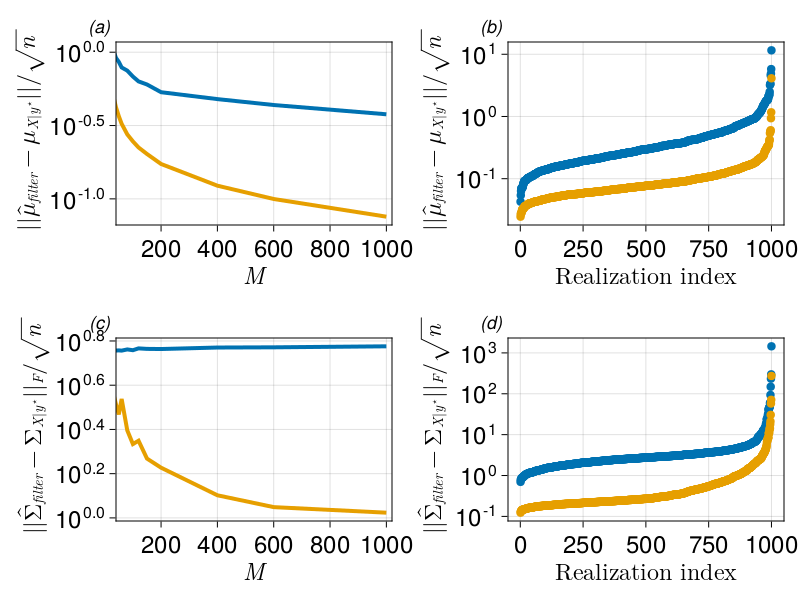

In [222]:
f = Figure(fontsize = 24, font = "TeX Heros Italic")

ga = f[1,1] = GridLayout()
gb = f[1,2] = GridLayout()
gc = f[2,1] = GridLayout()
gd = f[2,2] = GridLayout()


axa = Axis(f[1,1],
     xlabel = L"M",
     xticks = [200, 400, 600, 800, 1000],
     yscale = log10,
     ylabel = L"||\hat{\mu}_{filter} - \mu_{X | y^\star}||/\sqrt{n}"
)
lines!(axa, Ne_list, mean(eμ_finite_truepost_enkf, dims = 2)[:, 1], label  = L"\text{EnKF}", linewidth = 4)
lines!(axa, Ne_list, mean(eμ_finite_truepost_enrf, dims = 2)[:, 1], label  = L"\text{EnRF}", linewidth = 4)
xlims!(axa, (40, 1020))


axb = Axis(f[1,2],
     xlabel = L"\text{Realization index}",
     xticks = [0, 250, 500, 750, 1000],
     yscale = log10,
     ylabel = L"||\hat{\mu}_{filter} - \mu_{X | y^\star}||/\sqrt{n}"
)
scatter!(axb, sort(eμ_finite_truepost_enkf[11,:]), label  = L"\text{EnKF}", linewidth = 4)
scatter!(axb, sort(eμ_finite_truepost_enrf[11,:]), label  = L"\text{EnRF}", linewidth = 4)


axc = Axis(f[2,1],
     xlabel = L"M",
     xticks = [200, 400, 600, 800, 1000],
     yscale = log10,
     ylabel = L"||\hat{\Sigma}_{filter} - \Sigma_{X | y^\star}||_F / \sqrt{n}"
)
lines!(axc, Ne_list, mean(eΣ_finite_truth_enkf, dims = 2)[:, 1], label  = L"\text{EnKF}", linewidth = 4, 
    font = "CMU serif")
lines!(axc, Ne_list, mean(eΣ_finite_truth_enrf, dims = 2)[:, 1], label  = L"\text{EnRF}", linewidth = 4)
xlims!(axc, (40, 1020))

axd = Axis(f[2,2],
     xlabel = L"\text{Realization index}",
     xticks = [0, 250, 500, 750, 1000],
     yscale = log10,
     ylabel = L"||\hat{\Sigma}_{filter} - \Sigma_{X | y^\star}||_F / \sqrt{n}"
)
scatter!(axd, sort(eΣ_finite_truth_enkf[11,:]), label  = L"\text{EnKF}", linewidth = 4)
scatter!(axd, sort(eΣ_finite_truth_enrf[11,:]), label  = L"\text{EnRF}", linewidth = 4)


for (label, layout) in zip(["(a)", "(b)", "(c)", "(d)"], [ga, gb, gc, gd])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 18,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end

f

saveplot && save("plot_consistency.pdf", f)

f

In [224]:
# plt = plot()
# histogram!(plt, eμ_finite_truepost_enrf[10,:])
# histogram!(plt, eμ_finite_truepost_enkf[10,:])

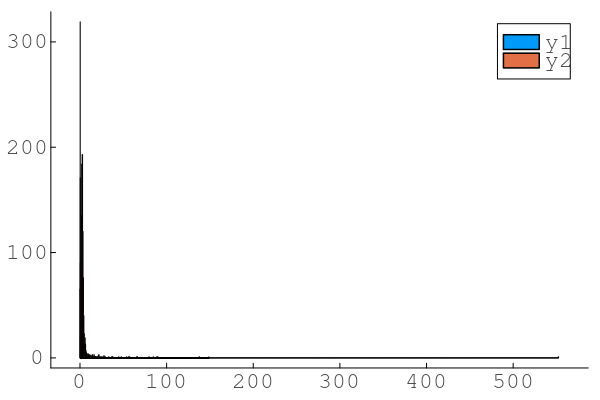

In [22]:
plt = plot()
histogram!(plt, eΣ_finite_truth_enrf[10,:])
histogram!(plt, eΣ_finite_truth_enkf[10,:])